In [1]:
# 自动重载模块
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# 添加 TPLC_Net 到路径
tplc_path = Path('..') / '..' / 'TPLC_Net'
if str(tplc_path.resolve()) not in sys.path:
    sys.path.insert(0, str(tplc_path.resolve()))

# 添加 scheme_1 到路径（以便导入 baselines）
scheme1_path = Path('..') / '..'
if str(scheme1_path.resolve()) not in sys.path:
    sys.path.insert(0, str(scheme1_path.resolve()))

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.pipeline import prepare_greenhouse_datasets, make_loaders
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything
from tplc_algo.exp_utils import (
    create_run_dir,
    save_config_json,
    save_env_json,
    save_history_csv,
    save_metrics_json,
    save_figure,
)

from baselines.TimesNet import TimesNetForecaster

print('导入完成！')

导入完成！


## 1. 配置参数

In [2]:
# ========= 基础配置 =========
seed_everything(42)

# 数据配置
dataset_root = (Path('..') / '..' / 'datasets' / '自主温室挑战赛').resolve()
team = 'AICU'  # 可选：Reference / IUACAAS / TheAutomators

seq_len = 288   # 输入序列长度（约 1 天，5 分钟频率）
pred_len = 72   # 预测长度（约 6 小时）
stride = 1      # 滑动窗口步长
batch_size = 32

# ========= TimesNet 模型配置 =========
d_model = 64        # Embedding 维度
d_ff = 128          # Feedforward 维度
e_layers = 2        # TimesBlock 层数
top_k = 3           # 提取 top-k 个主要周期
num_kernels = 6     # Inception Block 卷积核数量
dropout = 0.1

# ========= 训练配置 =========
epochs = 20
lr = 1e-3
weight_decay = 0.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 稳定性配置
use_amp = (device == 'cuda')
grad_clip_max_norm = 1.0
lr_scheduler = 'plateau'
plateau_patience = 3
plateau_factor = 0.5
early_stop_patience = 6

# ========= 实验目录 =========
exp_name = f"timesnet_greenhouse_{team}"
run_dir = create_run_dir(exp_name, base_dir=Path('.') / 'results')
ckpt_path = run_dir / 'checkpoints' / 'timesnet_best.pt'

print(f'Device: {device}')
print(f'Team: {team}')
print(f'Dataset root: {dataset_root}')
print(f'Run directory: {run_dir}')

Device: cuda
Team: AICU
Dataset root: D:\degree_code\scheme_1\datasets\自主温室挑战赛
Run directory: results\timesnet_greenhouse_AICU_20260116_164807


## 2. 数据准备

In [3]:
# 准备数据集
prepared = prepare_greenhouse_datasets(
    dataset_root=dataset_root,
    team=team,
    seq_len=seq_len,
    pred_len=pred_len,
    stride=stride,
    missing_rate_threshold=0.7,
    drop_constant=True,
    protect_target_cols=True,
)

feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
target_scaler = prepared.target_scaler

train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)

print(f'\n输入特征维度：{len(feature_cols)}')
print(f'目标特征维度：{len(target_cols)}')
print(f'目标特征：{target_cols}')
print(f'\n训练批次数：{len(train_loader)}')
print(f'验证批次数：{len(val_loader)}')
print(f'测试批次数：{len(test_loader)}')

D:\degree_code\scheme_1\TPLC_Net\tplc_algo\data\greenhouse_dataset.py:32: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



输入特征维度：101
目标特征维度：3
目标特征：['Tair', 'Rhair', 'CO2air']

训练批次数：1034
验证批次数：139
测试批次数：288


## 3. 构建 TimesNet 模型

In [4]:
model = TimesNetForecaster(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    d_model=d_model,
    d_ff=d_ff,
    e_layers=e_layers,
    top_k=top_k,
    num_kernels=num_kernels,
    dropout=dropout,
)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'模型参数量：{total_params:,}')
print(f'\n模型结构：')
print(model)

模型参数量：9,497,707

模型结构：
TimesNetForecaster(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(101, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (predict_linear): Linear(in_features=288, out_features=360, bias=True)
  (model): ModuleList(
    (0-1): 2 x TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(64, 128, kernel_size=(1

## 4. 训练模型

In [5]:
trainer = Trainer(
    model=model,
    cfg=TrainConfig(
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        device=device,
        ckpt_path=ckpt_path,
        use_amp=use_amp,
        grad_clip_max_norm=grad_clip_max_norm,
        lr_scheduler=lr_scheduler,
        plateau_patience=plateau_patience,
        plateau_factor=plateau_factor,
        early_stop_patience=early_stop_patience,
        show_progress=True,
        progress_granularity='epoch',
    )
)

history = trainer.fit(train_loader, val_loader=val_loader)

# 保存配置和历史
config_payload = {
    'team': team,
    'dataset_root': str(dataset_root),
    'seq_len': seq_len,
    'pred_len': pred_len,
    'stride': stride,
    'feature_cols': feature_cols,
    'target_cols': target_cols,
    'model': {
        'd_model': d_model,
        'd_ff': d_ff,
        'e_layers': e_layers,
        'top_k': top_k,
        'num_kernels': num_kernels,
        'dropout': dropout,
    },
    'train': {
        'batch_size': batch_size,
        'epochs': epochs,
        'lr': lr,
        'weight_decay': weight_decay,
    }
}

save_config_json(run_dir, config_payload)
save_env_json(run_dir)
save_history_csv(run_dir, history)

print(f'\n训练完成！结果保存到：{run_dir}')

train (epoch):  30%|###       | 6/20 [16:57<39:33, 169.54s/epoch, train=0.0315, val=0.4041, stop=best@1]


训练完成！结果保存到：results\timesnet_greenhouse_AICU_20260116_164807


## 5. 训练曲线可视化

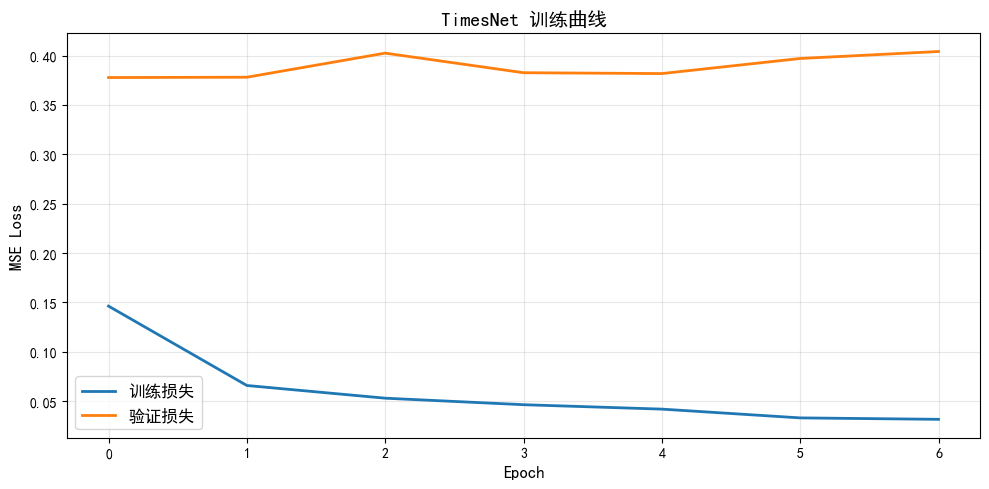

In [12]:
fig = plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='训练损失', linewidth=2)
if len(history.get('val_loss', [])) > 0:
    plt.plot(history['val_loss'], label='验证损失', linewidth=2)
plt.legend(fontsize=12)
plt.title('TimesNet 训练曲线', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'loss_curve.png')
plt.show()

## 6. 测试集评估

In [11]:
# 标准化指标
test_metrics = trainer.evaluate(test_loader)
print('测试集指标（标准化数据）：')
print(f"  Loss: {test_metrics['loss']:.4f}")
print(f"  MAE:  {test_metrics['mae']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")

# 反标准化指标（更直观）
model.eval()
y_true_list = []
y_pred_list = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_hat = model(x).cpu().numpy()
        y_true_list.append(y.numpy())
        y_pred_list.append(y_hat)

y_true = np.concatenate(y_true_list, axis=0)  # [N, pred_len, target_dim]
y_pred = np.concatenate(y_pred_list, axis=0)

# 反标准化
y_true_raw = target_scaler.inverse_transform(
    y_true.reshape(-1, len(target_cols))
).reshape(y_true.shape)
y_pred_raw = target_scaler.inverse_transform(
    y_pred.reshape(-1, len(target_cols))
).reshape(y_pred.shape)

test_metrics['mae_raw'] = float(np.mean(np.abs(y_true_raw - y_pred_raw)))
test_metrics['rmse_raw'] = float(np.sqrt(np.mean((y_true_raw - y_pred_raw) ** 2)))

print('\n测试集指标（原始尺度）：')
print(f"  MAE:  {test_metrics['mae_raw']:.4f}")
print(f"  RMSE: {test_metrics['rmse_raw']:.4f}")

save_metrics_json(run_dir, test_metrics)
print(f'\n指标已保存到：{run_dir / "artifacts" / "metrics.json"}')

测试集指标（标准化数据）：
  Loss: 2.1879
  MAE:  1.0025
  RMSE: 1.2961

测试集指标（原始尺度）：
  MAE:  29.0542
  RMSE: 60.6297

指标已保存到：results\timesnet_greenhouse_AICU_20260116_164807\artifacts\metrics.json


## 7. 预测结果可视化

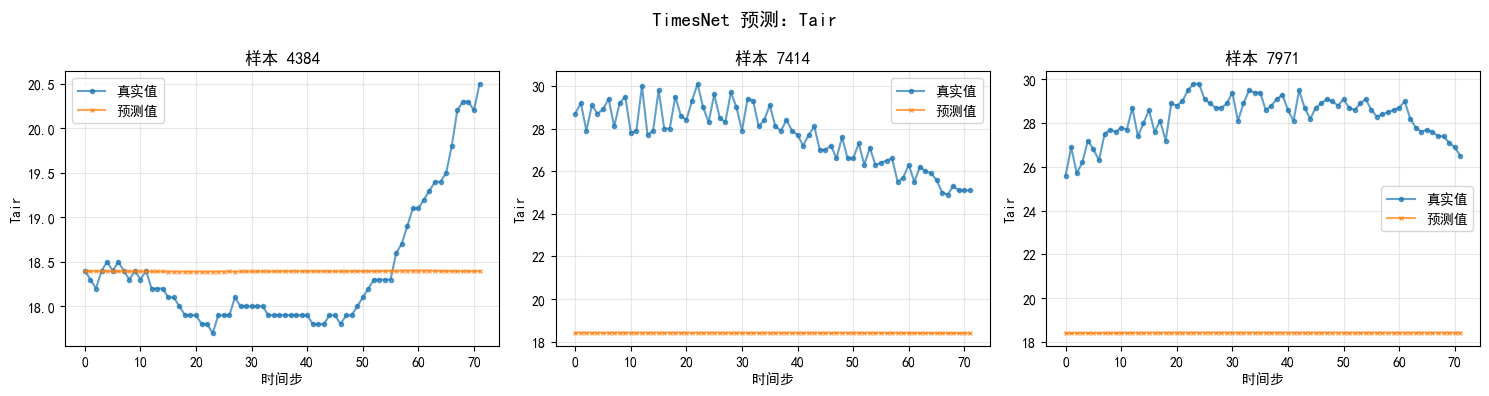

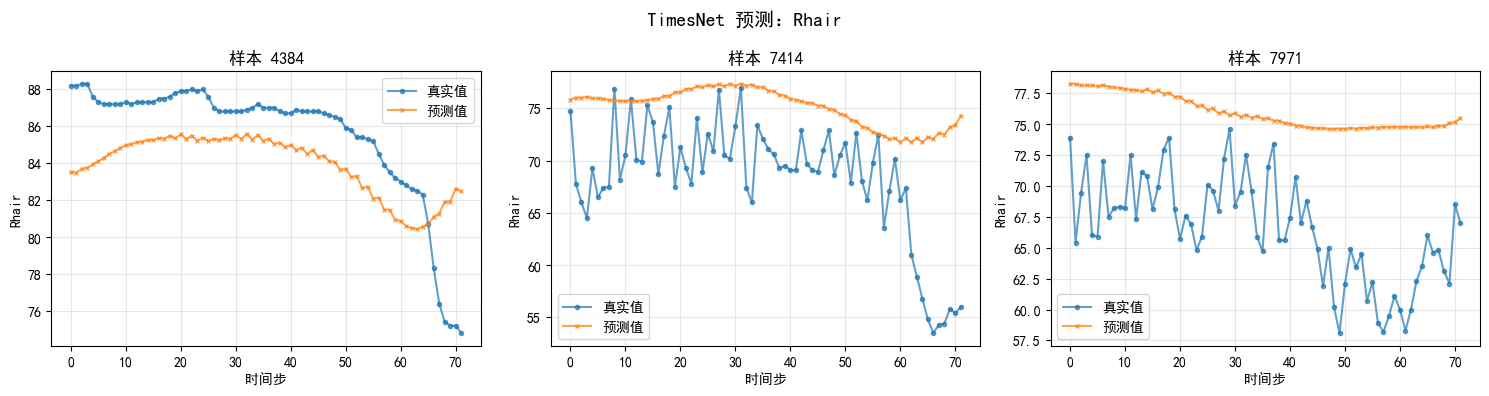

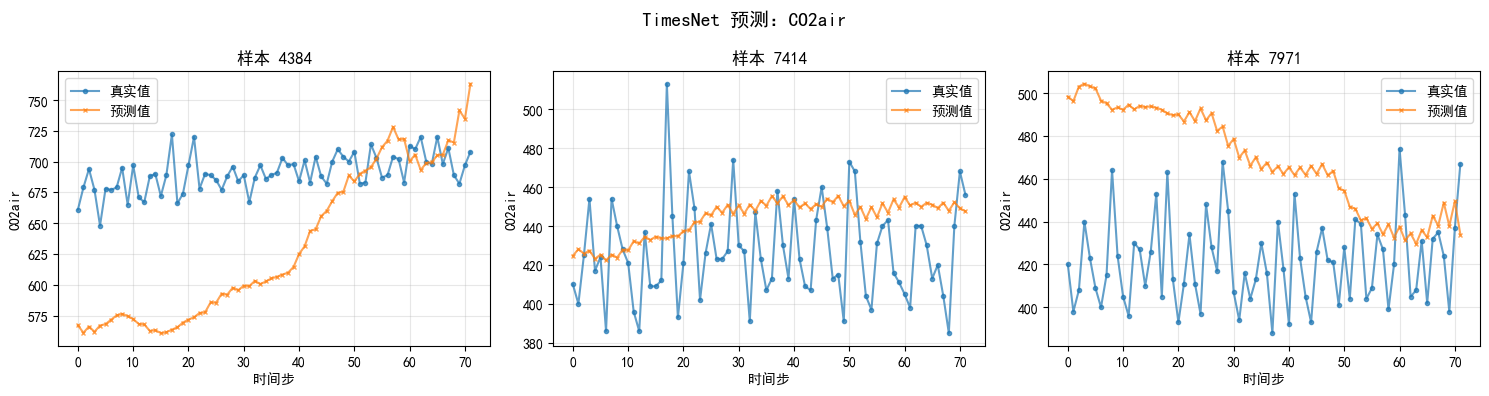

In [13]:
# 随机选择几个样本进行可视化
n_samples = min(3, len(y_true))
sample_indices = np.random.choice(len(y_true), n_samples, replace=False)

for var_idx, var_name in enumerate(target_cols):
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 4))
    if n_samples == 1:
        axes = [axes]
    
    for ax, sample_idx in zip(axes, sample_indices):
        ax.plot(y_true_raw[sample_idx, :, var_idx], label='真实值', marker='o', markersize=3, alpha=0.7)
        ax.plot(y_pred_raw[sample_idx, :, var_idx], label='预测值', marker='x', markersize=3, alpha=0.7)
        ax.set_title(f'样本 {sample_idx}')
        ax.set_xlabel('时间步')
        ax.set_ylabel(var_name)
        ax.legend()
        ax.grid(alpha=0.3)
    
    fig.suptitle(f'TimesNet 预测：{var_name}', fontsize=14)
    plt.tight_layout()
    save_figure(fig, run_dir / 'figures' / f'pred_curve_{var_name}.png')
    plt.show()

## 8. 误差分布分析

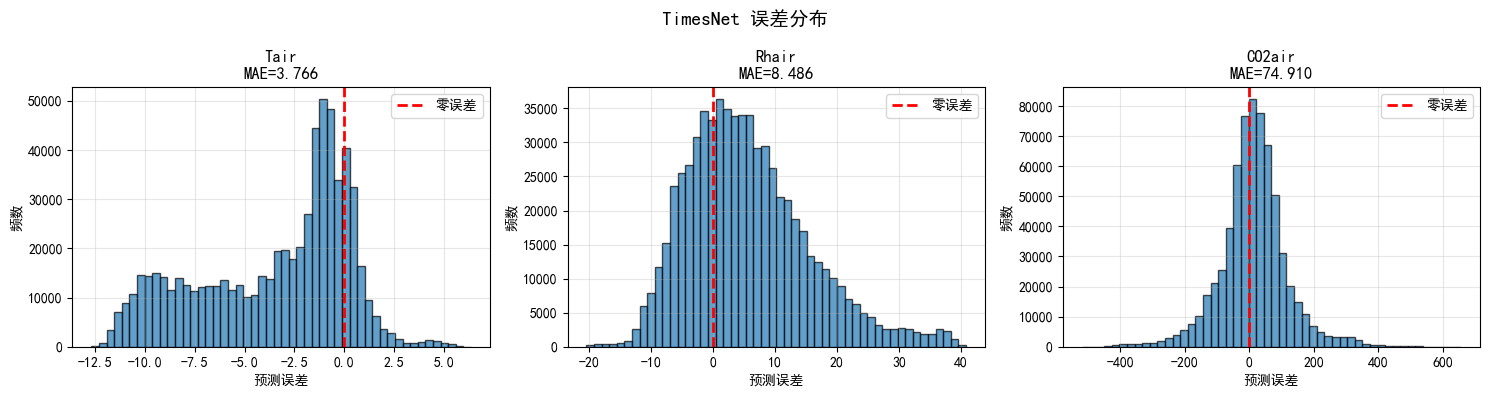

In [14]:
# 计算每个目标变量的误差
errors = y_pred_raw - y_true_raw  # [N, pred_len, target_dim]

fig, axes = plt.subplots(1, len(target_cols), figsize=(5 * len(target_cols), 4))
if len(target_cols) == 1:
    axes = [axes]

for ax, (var_idx, var_name) in zip(axes, enumerate(target_cols)):
    var_errors = errors[:, :, var_idx].flatten()
    ax.hist(var_errors, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='零误差')
    ax.set_title(f'{var_name}\nMAE={np.abs(var_errors).mean():.3f}')
    ax.set_xlabel('预测误差')
    ax.set_ylabel('频数')
    ax.legend()
    ax.grid(alpha=0.3)

fig.suptitle('TimesNet 误差分布', fontsize=14)
plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'error_distribution.png')
plt.show()

## 9. 按时间步的预测性能

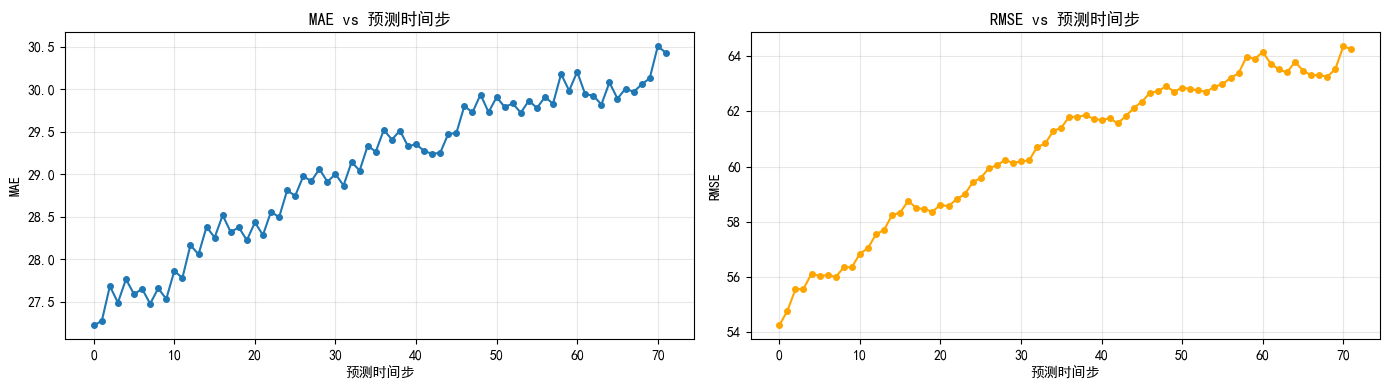


短期预测（前 12 步）MAE: 27.5816
长期预测（后 12 步）MAE: 30.0790


In [15]:
# 计算每个时间步的平均误差
mae_per_step = np.abs(errors).mean(axis=(0, 2))  # [pred_len]
rmse_per_step = np.sqrt((errors ** 2).mean(axis=(0, 2)))  # [pred_len]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(mae_per_step, marker='o', markersize=4)
axes[0].set_title('MAE vs 预测时间步')
axes[0].set_xlabel('预测时间步')
axes[0].set_ylabel('MAE')
axes[0].grid(alpha=0.3)

axes[1].plot(rmse_per_step, marker='o', markersize=4, color='orange')
axes[1].set_title('RMSE vs 预测时间步')
axes[1].set_xlabel('预测时间步')
axes[1].set_ylabel('RMSE')
axes[1].grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, run_dir / 'figures' / 'error_per_step.png')
plt.show()

print(f'\n短期预测（前 12 步）MAE: {mae_per_step[:12].mean():.4f}')
print(f'长期预测（后 12 步）MAE: {mae_per_step[-12:].mean():.4f}')

## 总结

TimesNet 通过 FFT 提取周期信息并使用 2D 卷积建模，适合处理具有明显周期性的时间序列数据。

**优点：**
- 能够自动发现时间序列的主要周期
- 2D 卷积有效捕获周期内和周期间的关系
- 参数高效，训练速度较快

**适用场景：**
- 具有明显周期性的数据（如温室环境的昼夜变化）
- 需要多尺度建模的时间序列
- 短期和长期预测任务